# 7. Transfer Learning for CNNs

In this notebook we load a small datasets that contains pictures of dolphins and elephants. We classify the images using CNNs and compare two approaches to see what works better:
1. Training a CNN from scratch.
2. Finetuning a pretrained ResNet.

In [1]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets

torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Let's load our data and have a look at the shape of some images:

In [2]:
dataset = datasets.ImageFolder(root='./data/animals')
for i, data in enumerate(dataset):
    print(data)
    if i == 5:
        break

(<PIL.Image.Image image mode=RGB size=300x179 at 0x7BDEB9D0D6D0>, 0)
(<PIL.Image.Image image mode=RGB size=300x179 at 0x7BDEB9D0D2B0>, 0)
(<PIL.Image.Image image mode=RGB size=300x166 at 0x7BDEB9D0D5E0>, 0)
(<PIL.Image.Image image mode=RGB size=300x259 at 0x7BDEB9D0DDF0>, 0)
(<PIL.Image.Image image mode=RGB size=300x225 at 0x7BDEB9D0D6D0>, 0)
(<PIL.Image.Image image mode=RGB size=300x277 at 0x7BDEB9D0D940>, 0)


We see that the pictures have all `width=300` but a varying height. To use them in transfer learning they need to have the standard shape of size `(224, 224)`, which is the data format of ImageNet (on which most pretrained models are trained on).  

To get them into this shape, we first define a transformation that increases the image height to 224 (this will also increase the width) and then take the 224 pixel center square of the picture:

In [3]:
image_transforms = transforms.Compose([
             transforms.Resize(size=224),
             transforms.CenterCrop(size=224),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # standard normalization for transfer learning
    ])

With this transformation, we now load all images from the disk.

Next, we split the data into train and test and define the data loaders that loads the data from disk.

In [4]:
data = datasets.ImageFolder(root='./data/animals', transform=image_transforms)
train_set, test_set = torch.utils.data.random_split(data, [100, 29])

batch_size = 10

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=29,
                                         shuffle=False)

## Tasks:
### Task 1.
Train a CNN from scratch to identify the object on the image (dolphin or elephant). For this, use the same CNN architecture as in cell 7 of the notebook from last week `06_CNNs.ipynb`. To make this work, here are a few things you need to change:
1. You need to change the input size of the fully-connected layer to match the new image dimension.
2. You need to change the output dimension of the fully-connected layer to classify only two classes instead of ten.
3. We now used a dataloader to load the data (see cell above), which allows us to train our model in mini-batches (aka "mini-batch gradient descent"). You can see [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network), how you can train the network using mini-batches given the `trainloader` from above.  

Train for 20 epochs on the train data and afterwards compute the accuracy on the test data.

In [5]:
# Train CNN from scratch

In [6]:
# Setup CNN
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(3, 4, 3) # rgb - left changed from 1 to 3
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4*111*111, 2)  # due to the padding the dimension stays the same

         # I changed the first convolution to take 3 input channels (for RGB) and produce 4 feature maps. 
         # After applying a 3×3 convolution, the 224×224 input becomes 222×222, 
         # and then the 2×2 max pooling cuts that in half to 111×111. 
         # That’s why the fully connected layer uses 4×111×111 as its input size.

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [7]:
# train network via mini-batches

def train(net):
    net.to(device)            # copy the model to the device 
    net.train()
    
    no_epochs = 20
    learning_rate = 0.01
    
    criterion = nn.CrossEntropyLoss()  
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
    losses = []
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return losses

In [8]:
cnn = CNN()
losses = train(cnn)

Finished Training


In [9]:
from sklearn.metrics import accuracy_score
def accuracy(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    print(f'Accuracy: {accuracy:.2f}%')

In [10]:
accuracy(cnn)

Accuracy: 72.41%


### Task 2:
Instead of training a CNN from scratch, we now want to load a pretrained **ResNet18** model and re-train its last layer to do our classifcation task.
PyTorch has a [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor) on transfer learning, which you can check to see how this works (note: its enough to read the section `ConvNet as fixed feature extractor`).

Train the last layer of the pre-trained RestNet model for 20 epochs and compare the results to task 1.

In [11]:
# Use transfer learning to train ResNet18 on the datasset
# compare results to newly self-trained model

In [ ]:
## Load ResNet18
from torch.optim import lr_scheduler 

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')


## Switch out last layer (fully connected) for own layer
# - Because
#   - We have to define specific output classes
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# out_features is the size of the output layer (number of classes).
# in_features is the size of the input to that layer (the number of incoming features).
print(f"In-features of the final layer: {model_conv.fc.in_features}")
print(f"Out-features of the final layer: {model_conv.fc.out_features}")

# Wir nehmen die in_features des letzten fully connected layers: hier gennant: fc
# und nehmen diese als input features für unser eigenes fully connected layer. -> 
# Da wir dieses Layer ja überschreiben wollen



## Switch Optimizer
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In-features of the final layer: 512
Out-features of the final layer: 2


In [13]:
# train prepared pre-trained model

losses = train(model_conv)

Finished Training


In [14]:
accuracy(model_conv)

Accuracy: 72.41%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


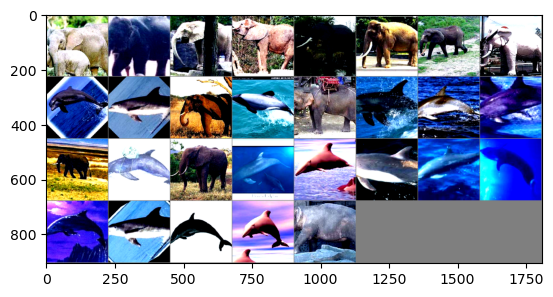

GroundTruth:  elephant elephant elephant elephant


In [18]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('dolphin','elephant')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))